In [1]:
import math
import itertools

import pandas as pd
from sqlalchemy.sql import select

from predict_aqi.load_data import (
    AirLocation, get_db_session, load_air_location_data, load_measurement_data,
    load_nearby_location_measurement_data
)

# Select some airlocation with bad aqi
session = get_db_session()
s = select([AirLocation]).where(AirLocation.aqi > 100)
some_airlocation_ids = [x['id'] for x in session.execute(s)]

/opt/conda/lib/python3.5/site-packages/sqlalchemy/dialects/postgresql/base.py:2503: SAWarning: Did not recognize type 'geometry' of column 'coordinates'
  (attype, name))


In [13]:
# Select classifier to use
from sklearn.neural_network import MLPRegressor
from predict_aqi.model import generate_AQI_inputs_and_outputs
from predict_aqi import config
from predict_aqi.transform_data import clean_data


def load_data_for_airlocation(airlocation_id):
    indices_ahead_to_predict = range(2, config.NUMBER_AHEAD_TO_PREDICT + 2, 2)
    indices_behind_to_use = range(1, MAX_INDEX)
    some_airlocation = load_air_location_data(airlocation_id)
    
    print("Loading {}, {}".format(some_airlocation.short_name, some_airlocation.en_country_name))
    
    measurements = load_measurement_data(airlocation_id)
    df, input_columns, output_columns = generate_AQI_inputs_and_outputs(
        measurements, indices_behind_to_use, indices_ahead_to_predict
    )
    return clean_data(df, input_columns), input_columns, output_columns

In [14]:
from predict_aqi.single_city_model import (
    generate_predictions, get_first_step_functions, get_second_step_functions
)
from sklearn.metrics import mean_absolute_error
import copy

MAX_INDEX = 48
INDICES_BEHIND_TO_USE_RANGE = range(1, MAX_INDEX + 1, 4)
INDICES_AHEAD_TO_PREDICT = range(2, config.NUMBER_AHEAD_TO_PREDICT + 2, 2)


def generate_errors_for_airlocation_predictions(df, input_columns, output_columns):
    
    row_count = df.count()[0]
    split_row = int(round(row_count * 0.90))
    
    errors = {}
    
    for indices_behind_to_use_index in INDICES_BEHIND_TO_USE_RANGE:
        current_input_columns = copy.deepcopy(input_columns[:indices_behind_to_use_index])
        first_step_format_inputs_outputs, first_step_split_function = get_first_step_functions(
            current_input_columns, output_columns
        )
        second_step_format_inputs_outputs, second_step_split_function = get_second_step_functions(
            current_input_columns, output_columns, INDICES_AHEAD_TO_PREDICT
        )
        
        first_step_regressor = MLPRegressor()
        second_step_regressor = MLPRegressor()
        this_iteration_df = df.copy(deep=True)
        this_iteration_df = generate_predictions(
            this_iteration_df,
            first_step_format_inputs_outputs,
            first_step_split_function,
            second_step_format_inputs_outputs,
            second_step_split_function,
            first_step_regressor,
            second_step_regressor,
            INDICES_AHEAD_TO_PREDICT,
            False
        )
        this_iteration_error_dict = {'first_step': {}, 'second_step': {}}
        for i in INDICES_AHEAD_TO_PREDICT:
            this_iteration_error_dict['first_step'][i] = mean_absolute_error(
                this_iteration_df['{}_ahead_AQI'.format(i)][split_row:], 
                this_iteration_df['{}_ahead_first_step_pred'.format(i)][split_row:]
            )
            this_iteration_error_dict['second_step'][i] = mean_absolute_error(
                this_iteration_df['{}_ahead_AQI'.format(i)][split_row:], 
                this_iteration_df['{}_ahead_second_step_pred'.format(i)][split_row:]
            )
        errors[indices_behind_to_use_index] = this_iteration_error_dict
        del this_iteration_df
    return errors

In [22]:
import matplotlib.pyplot as plt


def generate_error_graph(errors):
    first_step_errors = {
        i: [errors[i]['first_step'][key] * config.MAX_AQI 
            for key in sorted(errors[i]['first_step'].keys())]
        for i in INDICES_BEHIND_TO_USE_RANGE
    }
    
    second_step_errors = {
        i: [errors[i]['second_step'][key] * config.MAX_AQI 
            for key in sorted(errors[i]['second_step'].keys())]
        for i in INDICES_BEHIND_TO_USE_RANGE
    }
    plt.figure(figsize=(15, 10))
    plt.axis([0.0, 25.0, 0.0, 45.0])
    distances = sorted(first_step_errors.keys())
    for distance in distances:
        plt.plot(
            [d // 2 for d in INDICES_AHEAD_TO_PREDICT], 
            first_step_errors[distance], 
            label="{}hrs input first step error".format(distance / 2),
            color=str(distance / (max(distances) + 2))
        )
        plt.plot(
            [d // 2 for d in INDICES_AHEAD_TO_PREDICT],
            second_step_errors[distance], 
            label="{}hrs input second step error".format(distance / 2),
            color=str(distance / (max(distances) + 2))
        )
    plt.legend(loc=6, bbox_to_anchor=(0.5, 0))
    plt.suptitle("Absolute AQI error on predictions for the next 24 hours", fontsize=20)
    return first_step_errors, second_step_errors

Loading Mudanjiang, China


/home/jovyan/work/predict_aqi/transform_data.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['all_input_equal'] = df[input_columns].apply(lambda x: len(set(x)) < 3, axis=1)


Loading Delhi/ITO, India
Loading Ziyang, China


Loading Leshan, China


Loading Yongzhou, China


Loading India/Bangalore/Peenya, India


Loading CN:Henan/濮阳/泓天威, None


Loading Philippines/Manila/Mandaluyong, Philippines


Loading India/Panchkula/Sector6Panchkula, India


Loading India/Varanasi/ArdhaliBazar, India


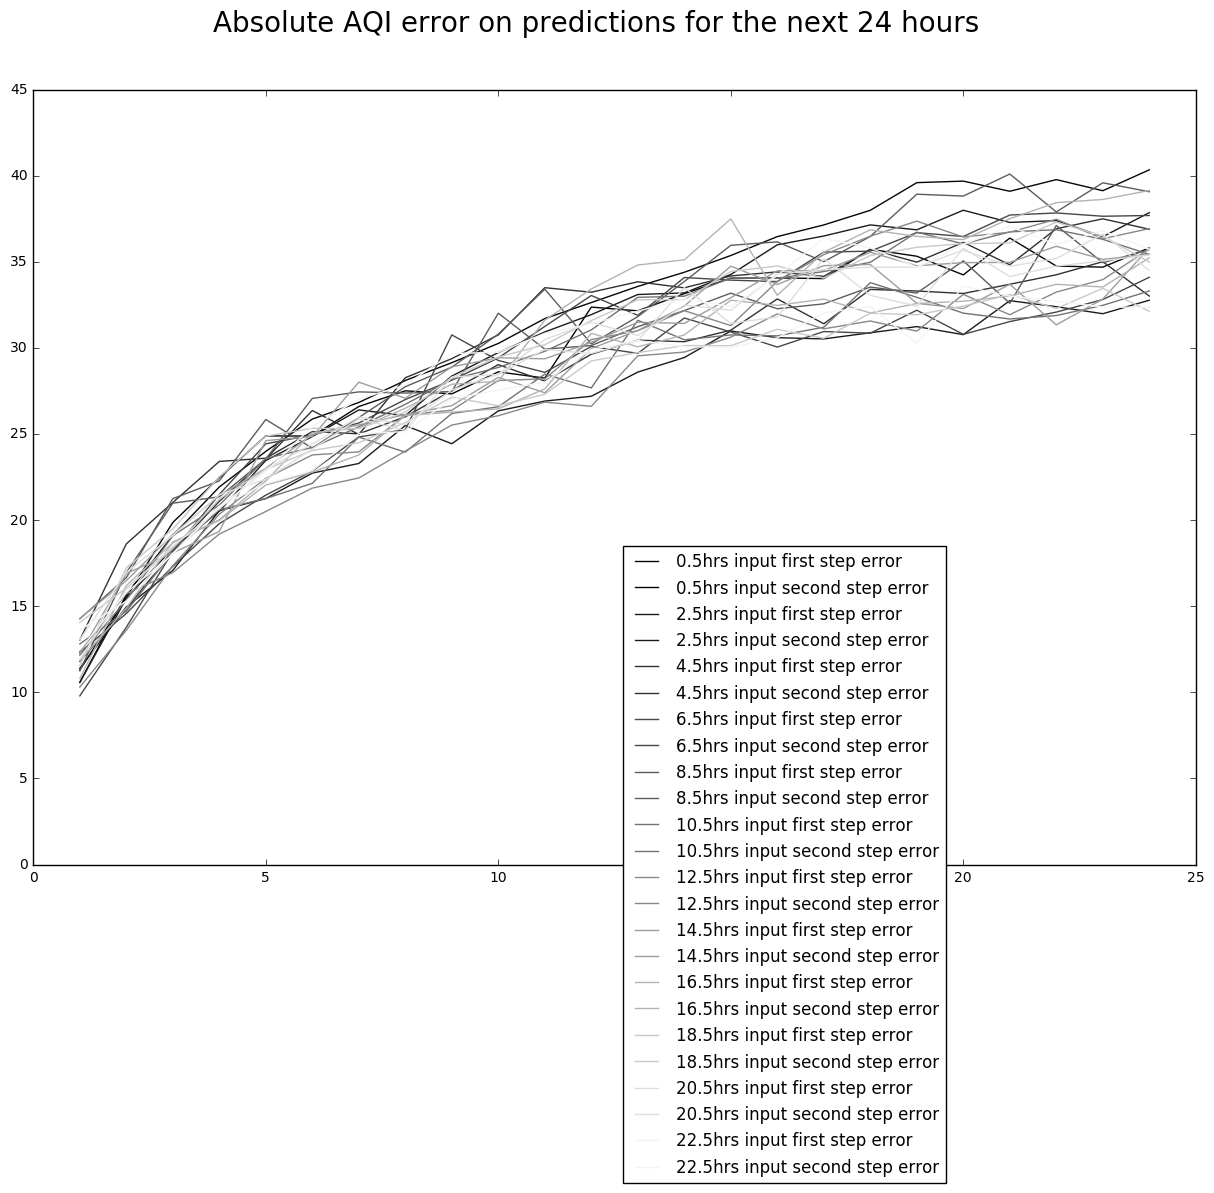

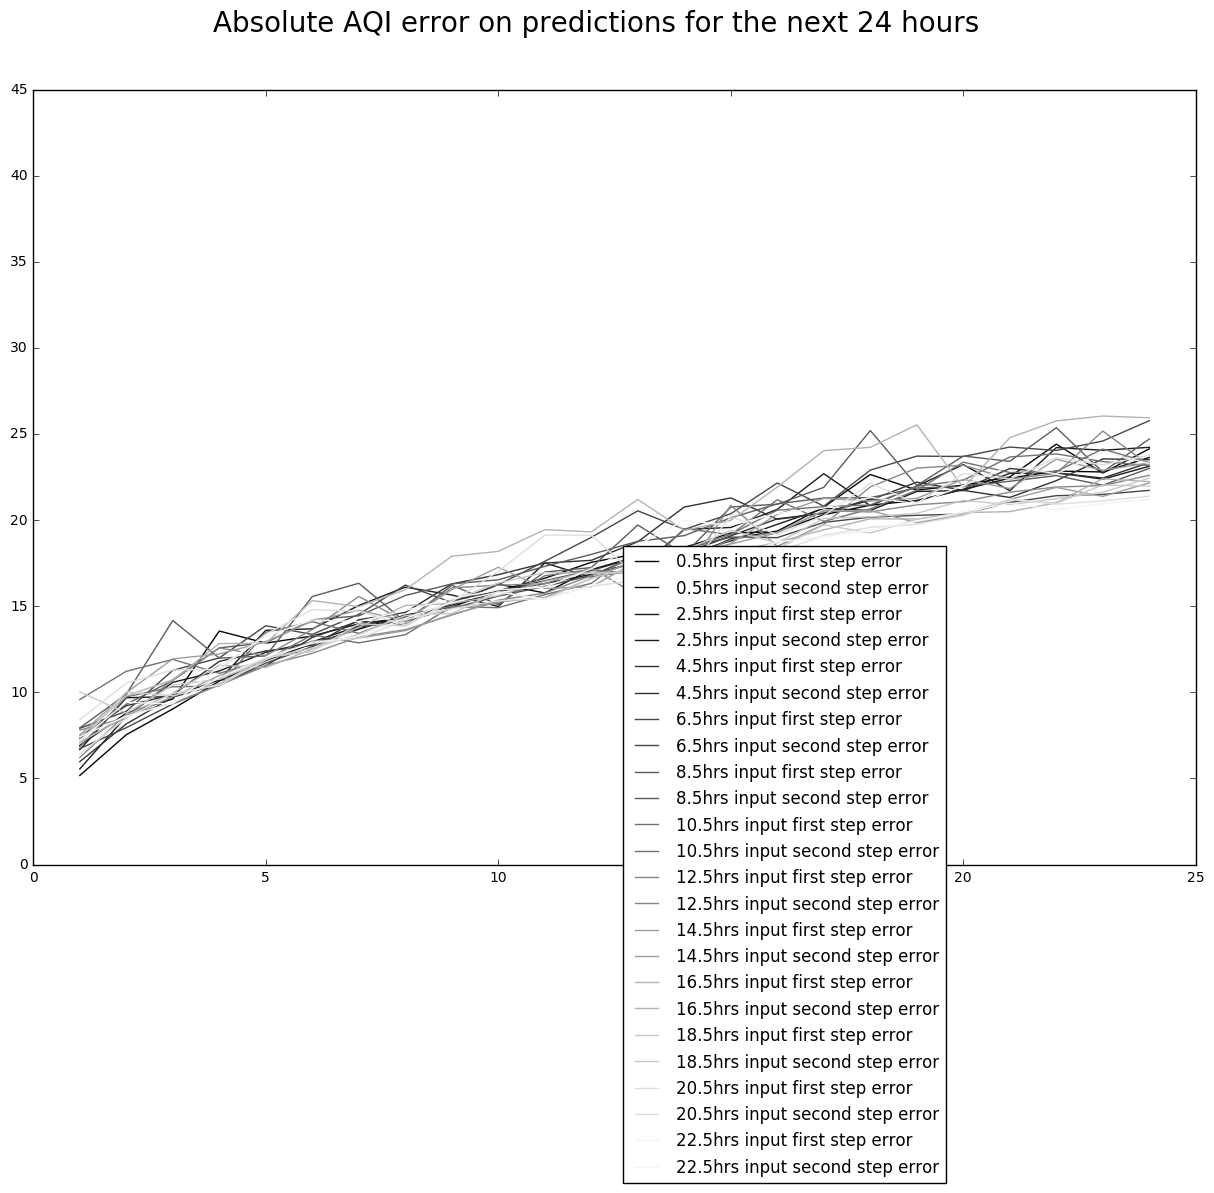

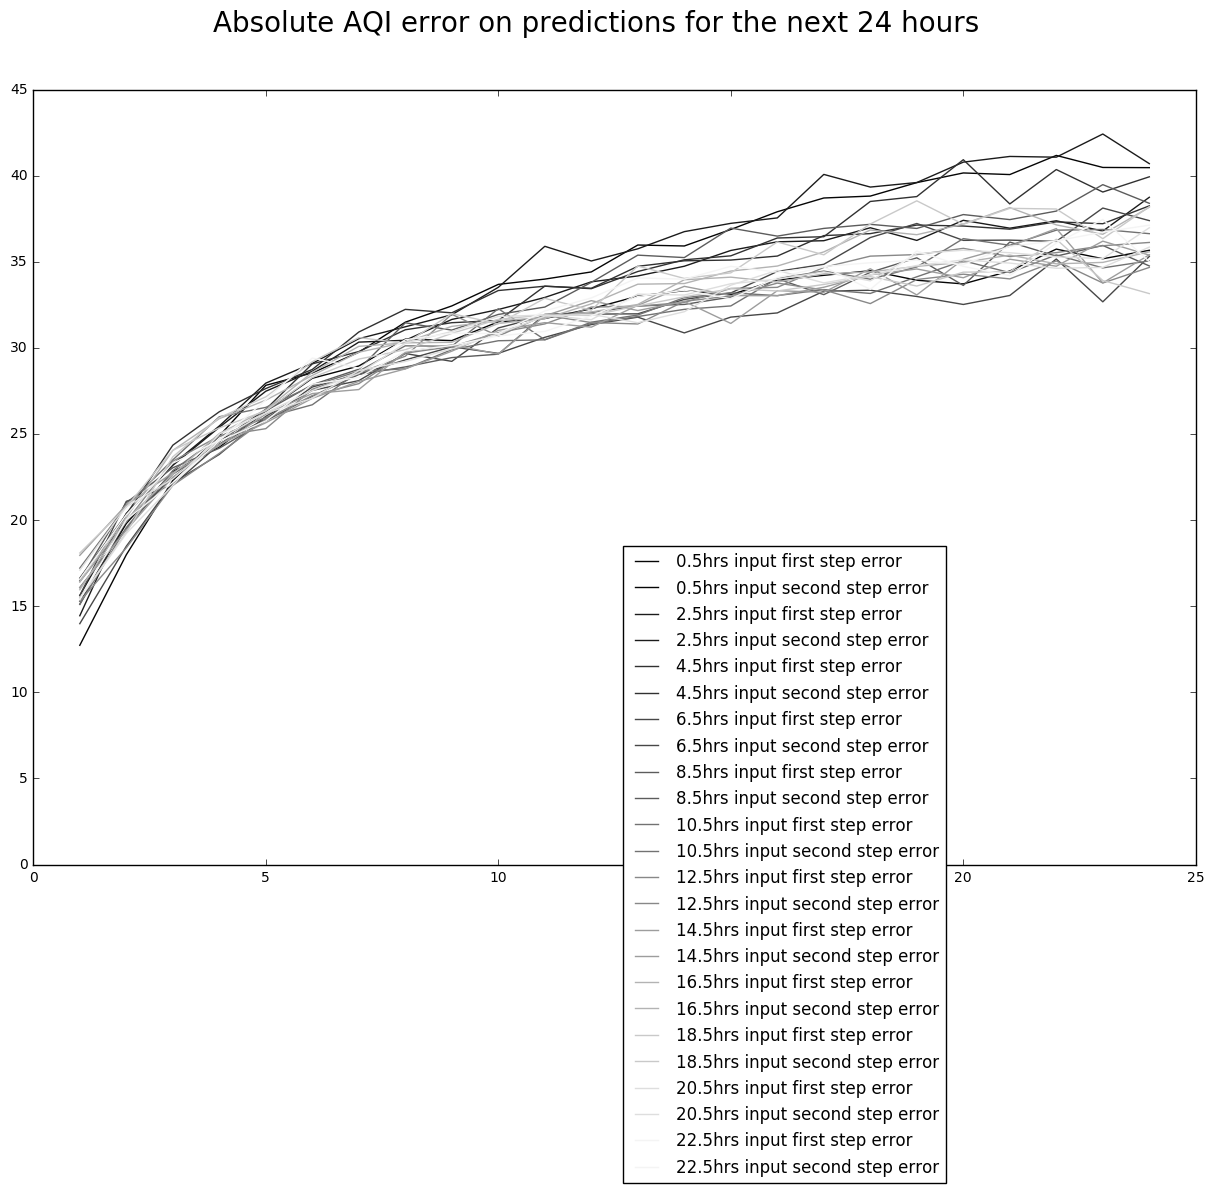

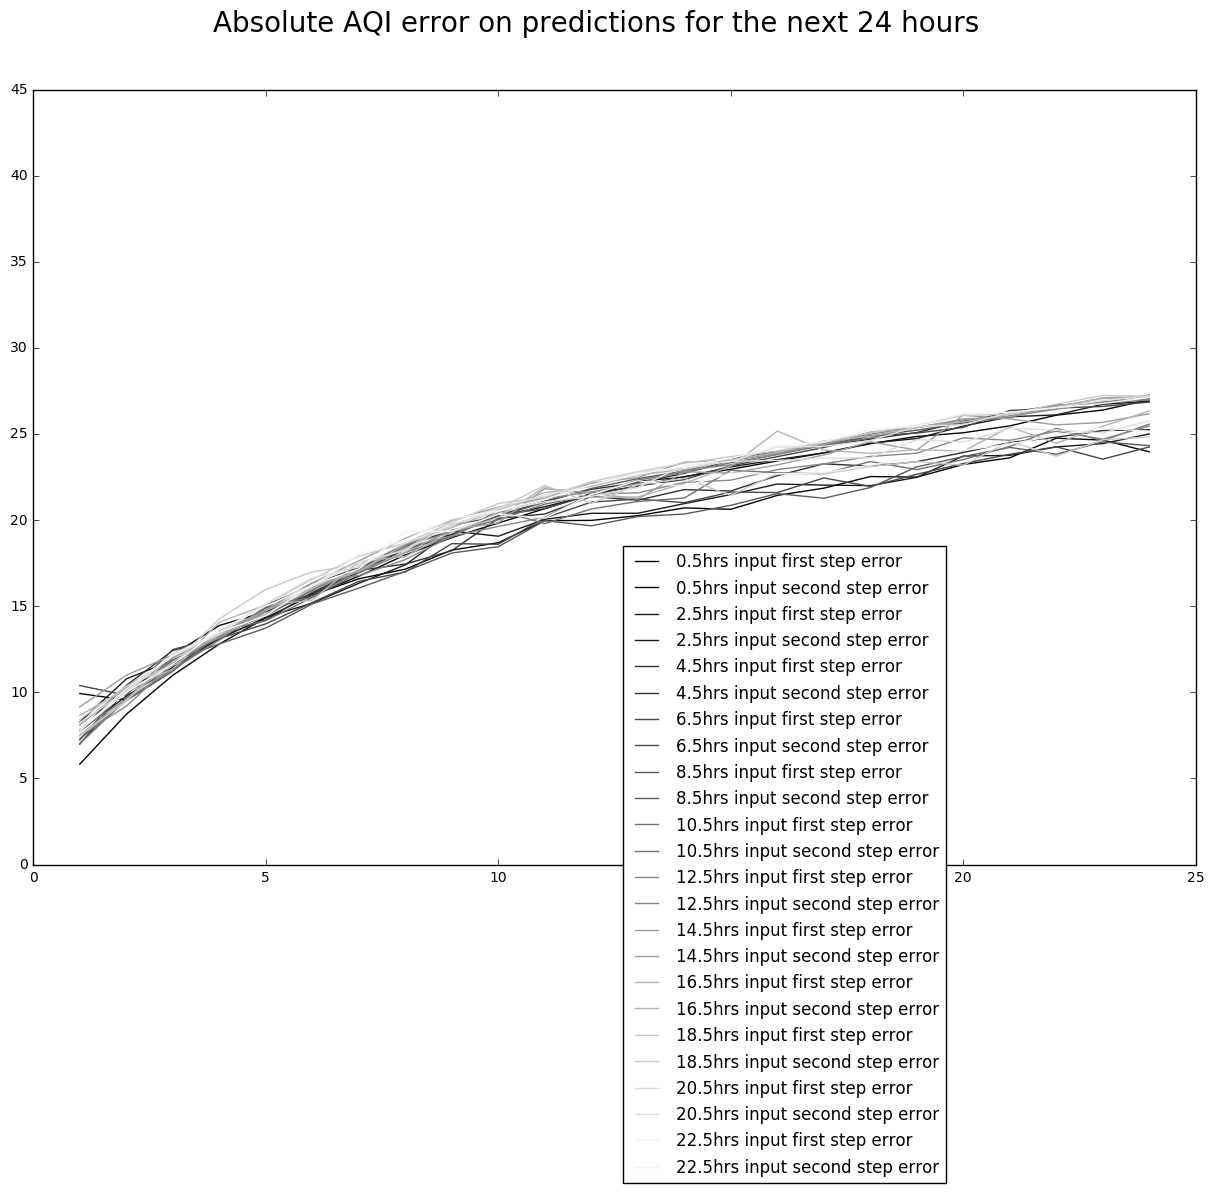

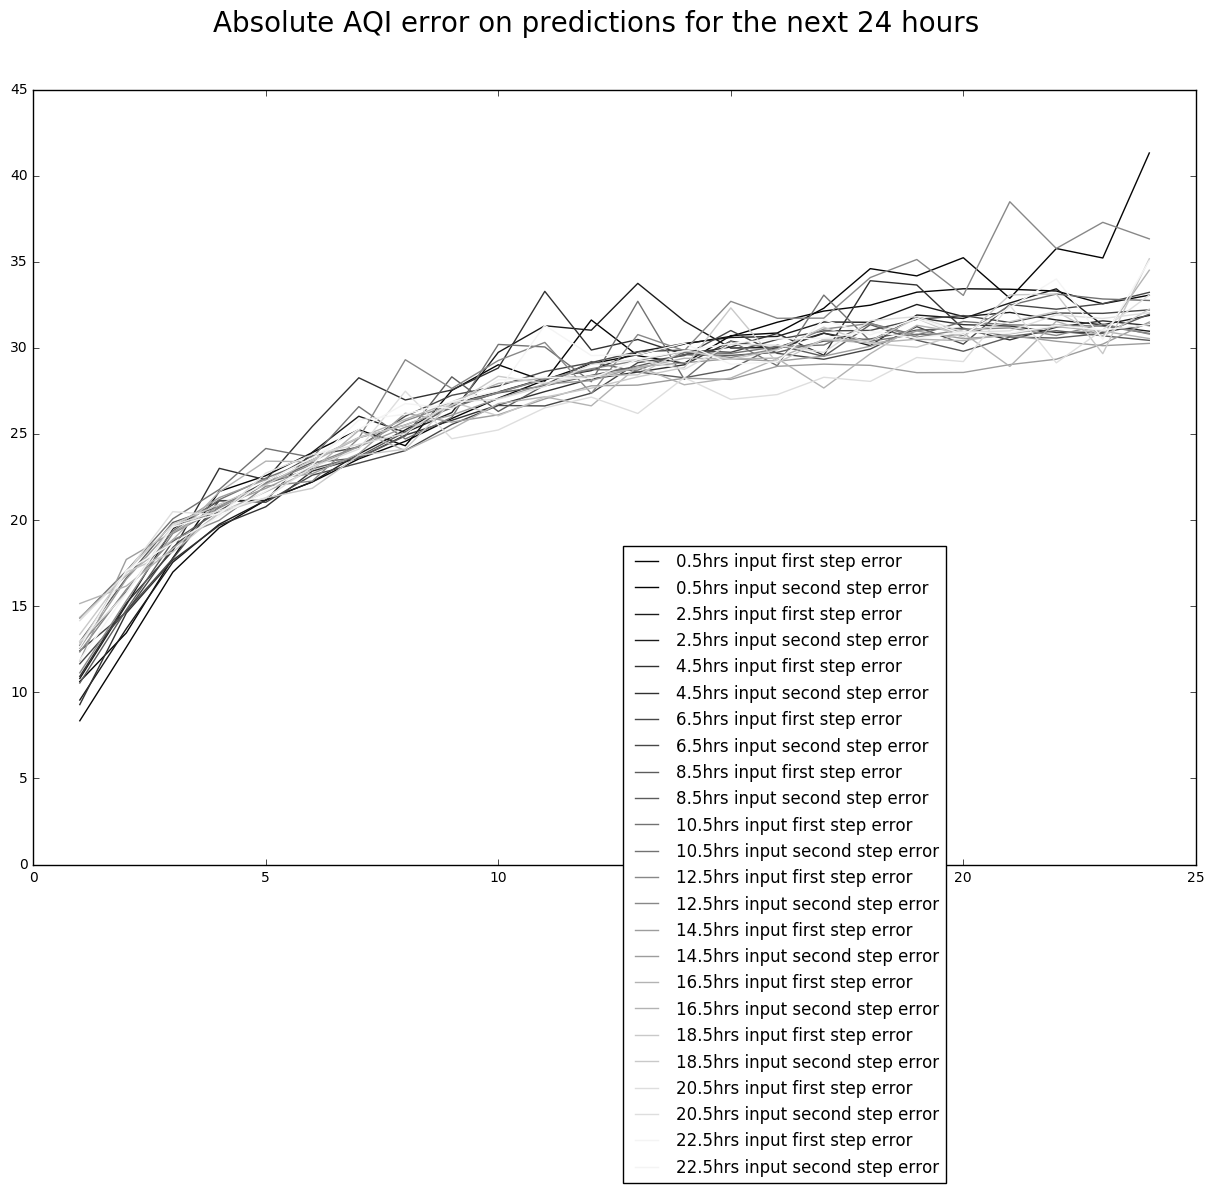

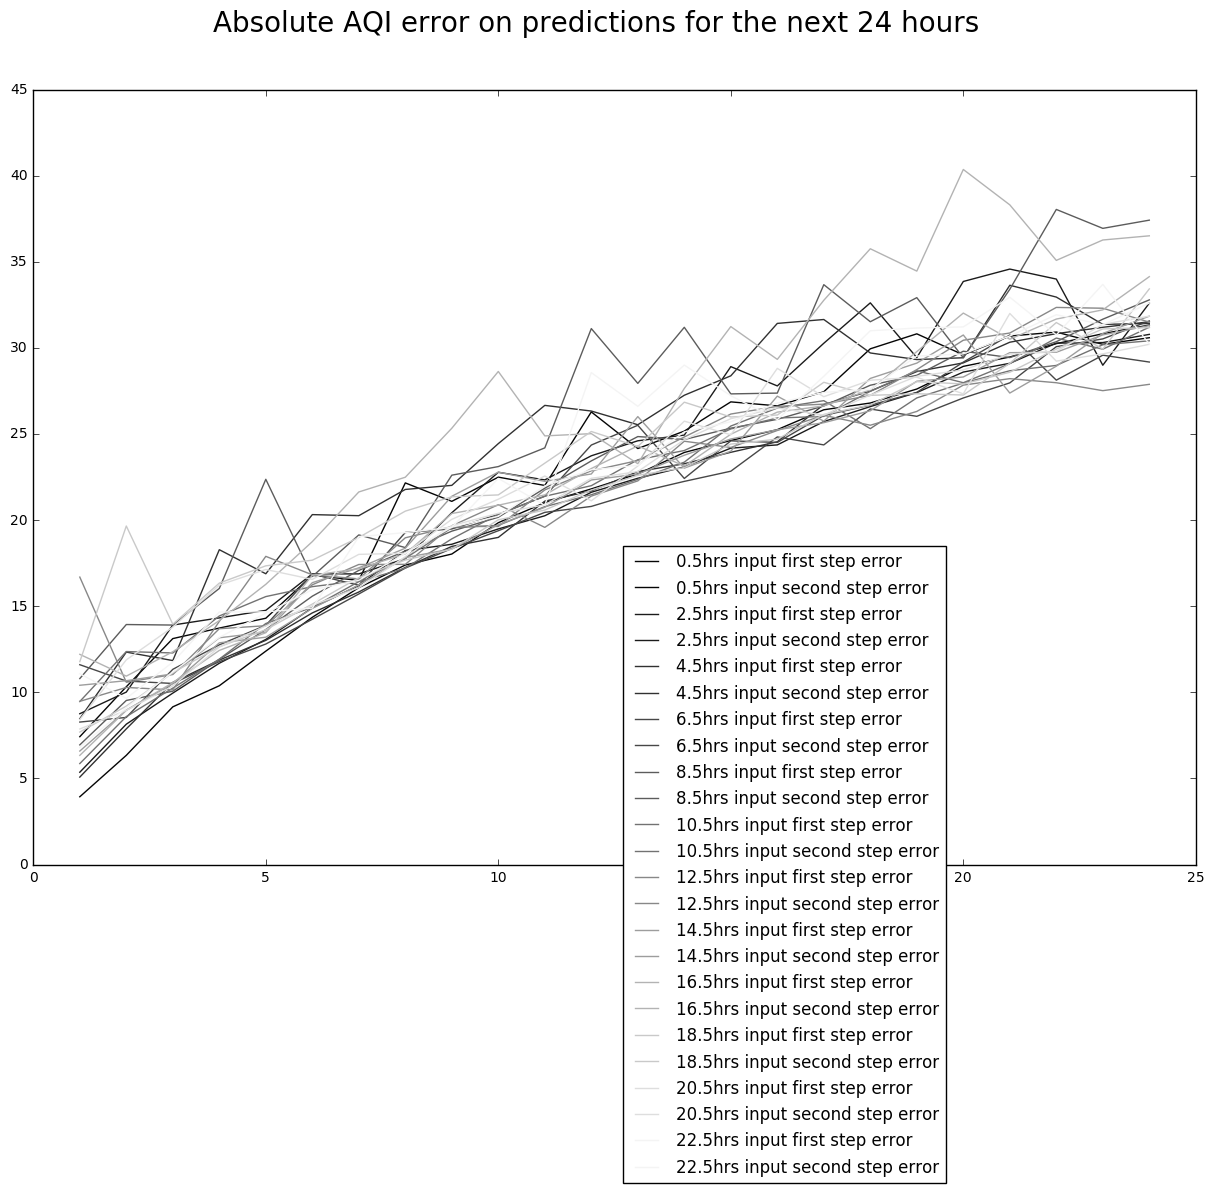

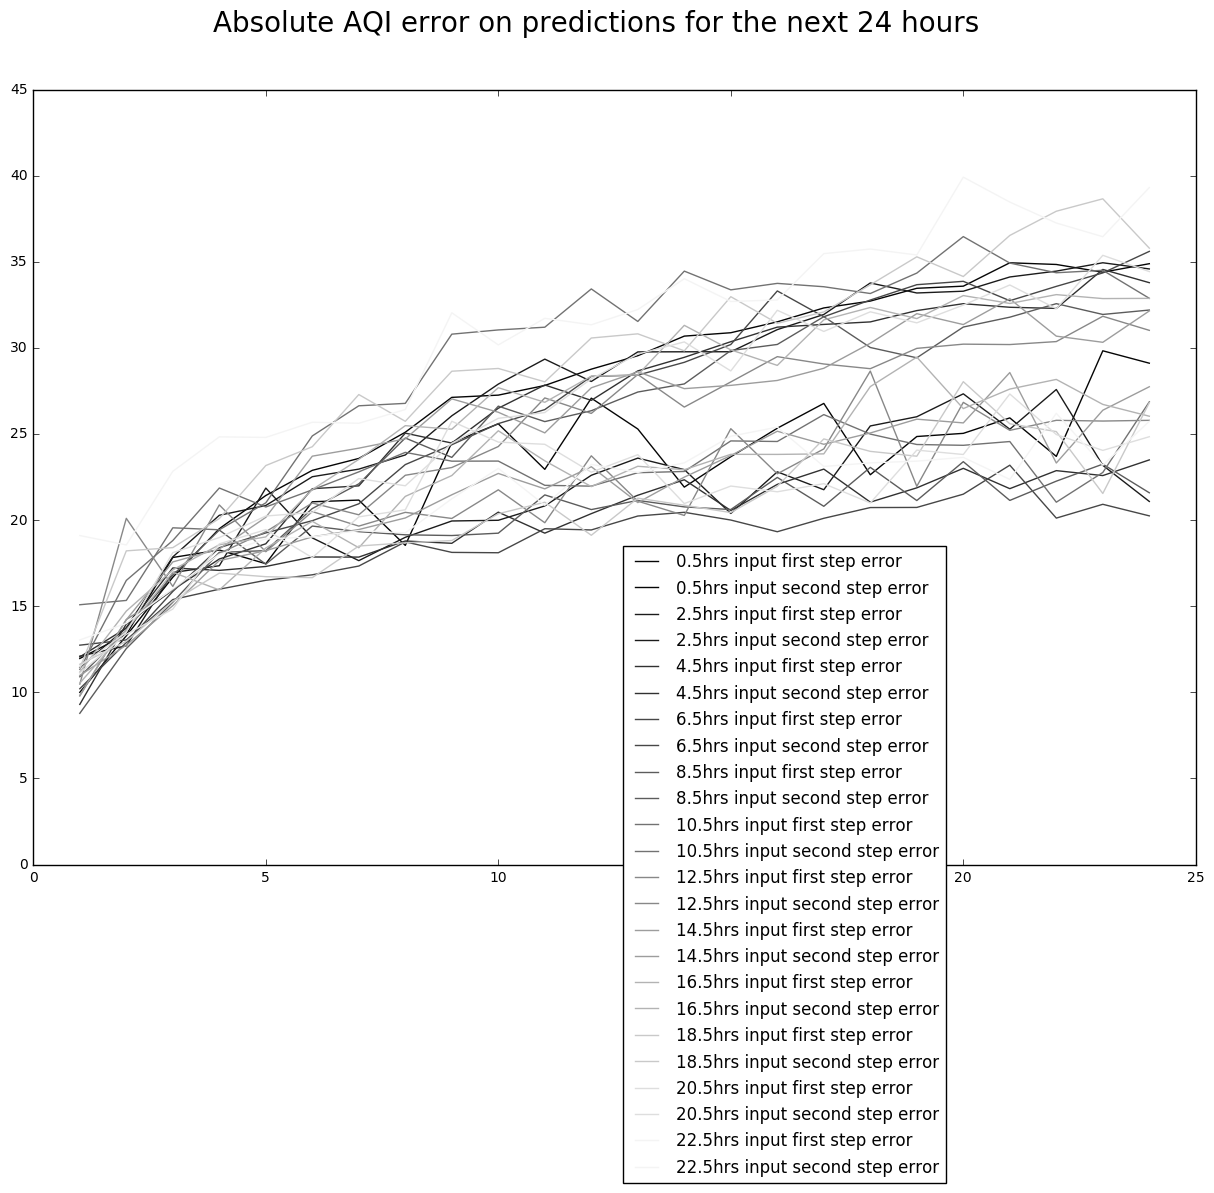

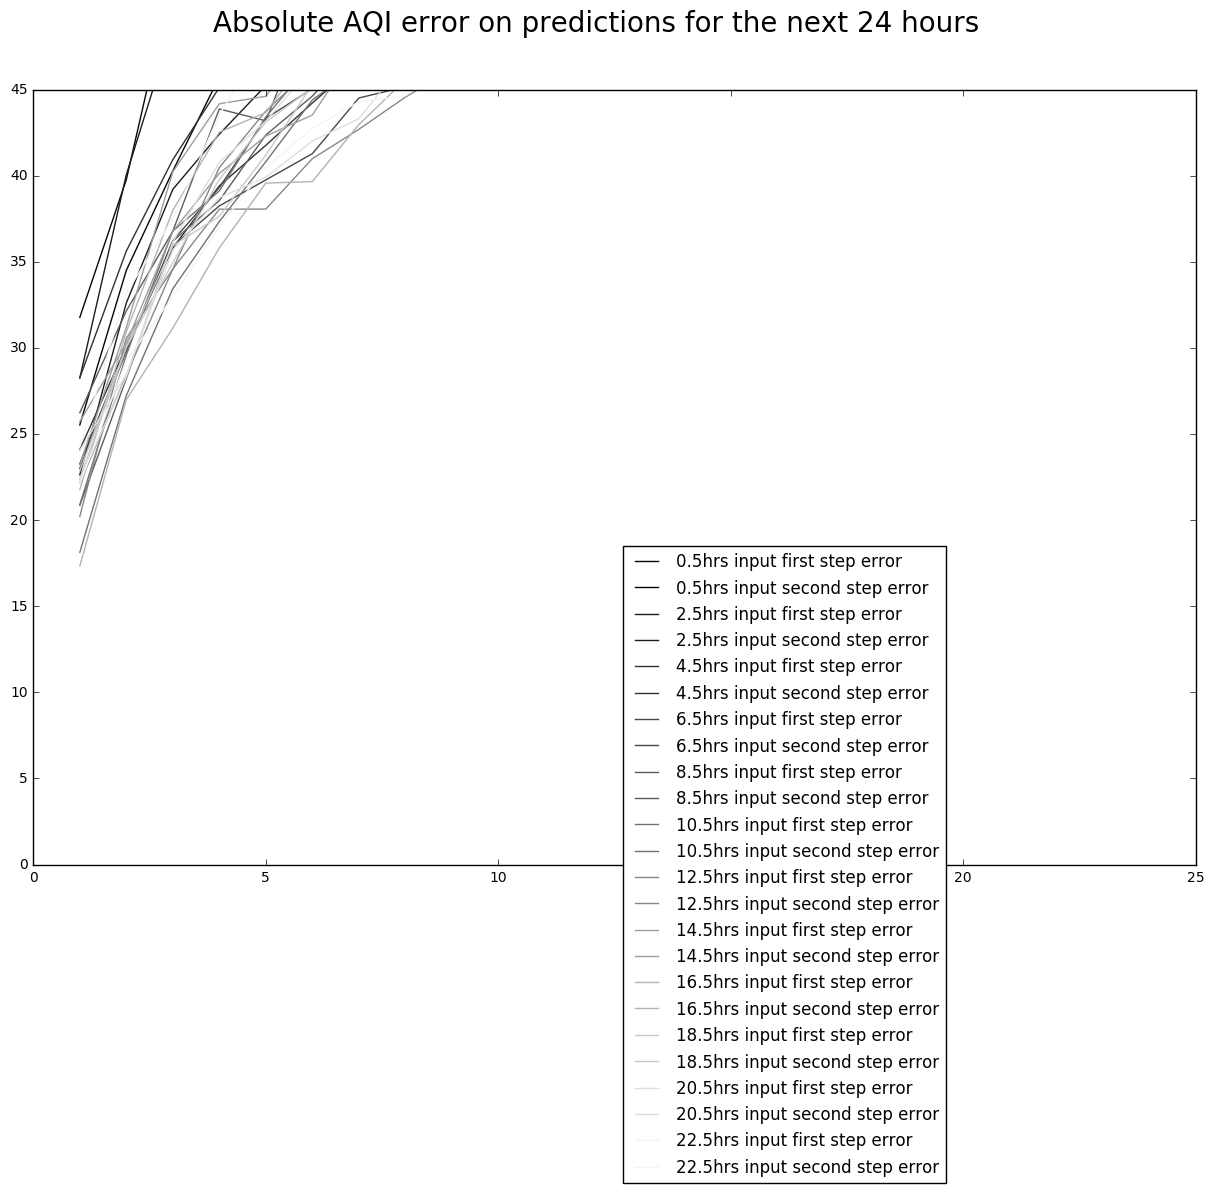

In [25]:
all_errors = []
NUMBER_OF_CITIES_TO_TEST = 10
for airlocation_id in some_airlocation_ids[0:NUMBER_OF_CITIES_TO_TEST]:
    df, input_columns, output_columns = load_data_for_airlocation(airlocation_id)
    if df.count()[0] < 1000:
        # not enough data to train on
        continue
    errors = generate_errors_for_airlocation_predictions(df, input_columns, output_columns)
    first_step_errors, second_step_errors = generate_error_graph(errors)
    all_errors.append((first_step_errors, second_step_errors))
    del df

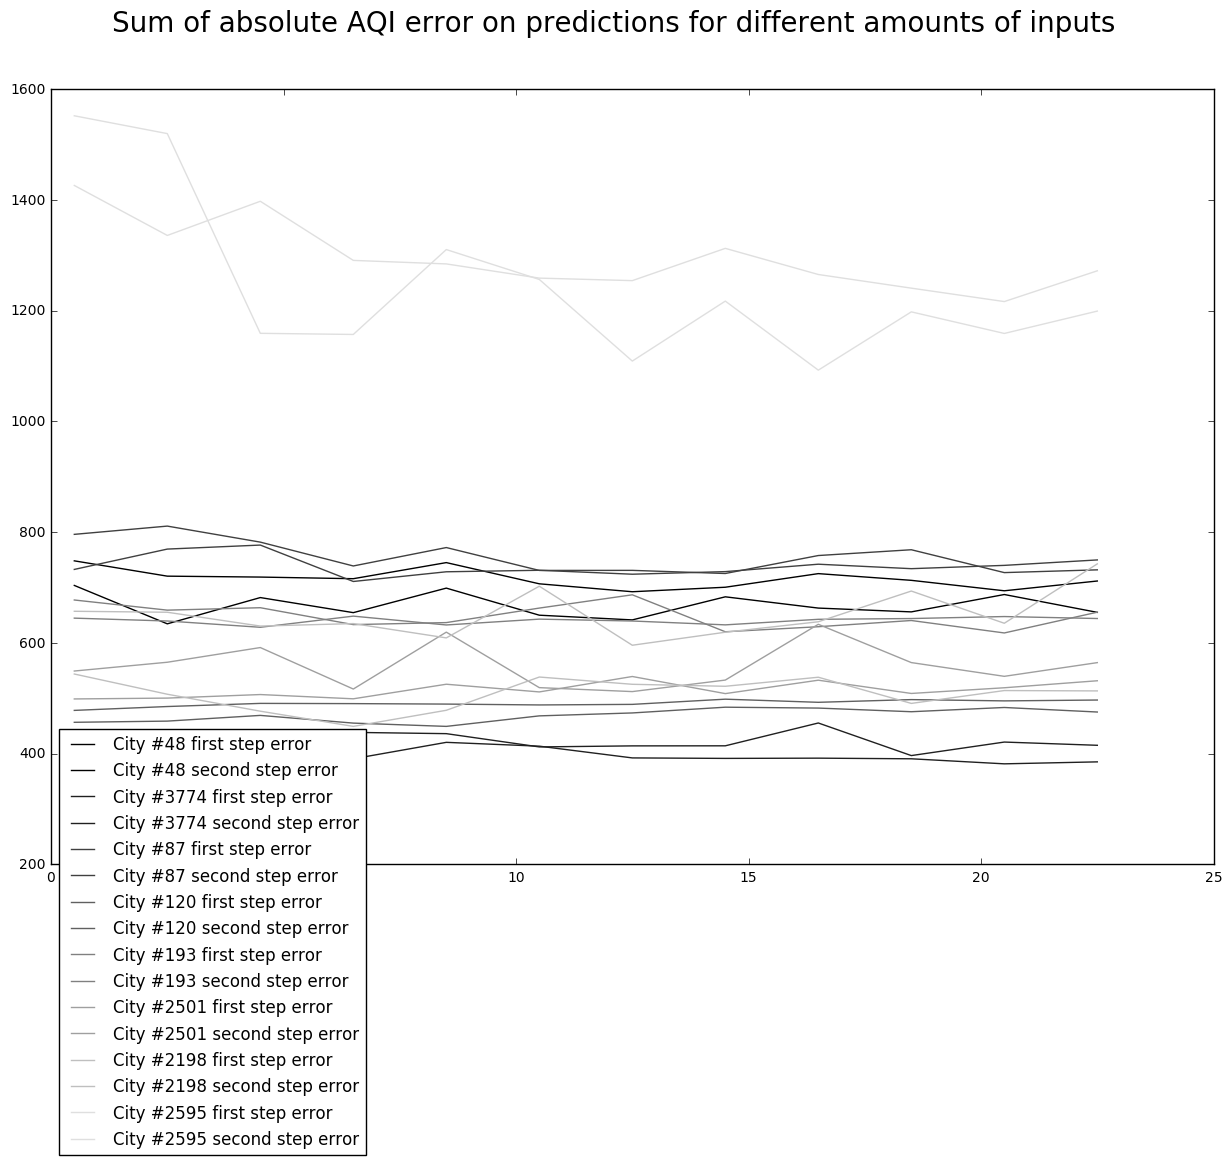

In [26]:
plt.figure(figsize=(15, 10))
#plt.axis([10.0, 40.0, 0.0, 25.0])
for index, (first_step_errors, second_step_errors) in enumerate(all_errors):
    xs = [d / 2 for d in sorted(first_step_errors.keys())]
    plt.plot(
        xs, 
        [sum(first_step_errors[d]) for d in sorted(first_step_errors.keys())],
        label="City #{} first step error".format(some_airlocation_ids[index]),
        color=str(index / len(all_errors))
    )
    plt.plot(
        xs,
        [sum(second_step_errors[d]) for d in sorted(second_step_errors.keys())],
        label="City #{} second step error".format(some_airlocation_ids[index]),
        color=str(index / len(all_errors))
    )
plt.legend(loc=6, bbox_to_anchor=(0, -0.1))
plt.suptitle("Sum of absolute AQI error on predictions for different amounts of inputs", fontsize=20)


# y = [sum(first_step_errors[d]) for d in sorted(first_step_errors.keys())]
# for distance in sorted(first_step_errors.keys()):
#     print("Distance into the past of inputs used: {}hrs".format(distance / 2))
#     print("Sum of absolute first step AQI prediction error: {}".format(
#         sum(first_step_errors[distance])
#     ))
#     print("Sum of absolute second step AQI prediction error: {}".format(
#         sum(second_step_errors[distance])
#     ))